# load and install data

In [1]:
!pip install librosa

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Preparation and EDA

In [3]:
folder_data = '/kaggle/input/pap-dataset/VIVAE/full_set'
files = os.listdir(folder_data)
files[:5]

['S07_surprise_moderate_06.wav',
 'S01_pain_peak_03.wav',
 'S01_surprise_peak_06.wav',
 'S09_pleasure_moderate_09.wav',
 'S07_pain_low_01.wav']

In [4]:
df = pd.DataFrame({'filenames': files})
df.head()

,filenames
0,S07_surprise_moderate_06.wav
1,S01_pain_peak_03.wav
2,S01_surprise_peak_06.wav
3,S09_pleasure_moderate_09.wav
4,S07_pain_low_01.wav


In [5]:
# (+) achievement, pleasure, and surprise
# (-) anger, fear, pain
df['labels'] = df['filenames'].apply(lambda x: x.split('_')[1])
df['labels'].unique()

array(['surprise', 'pain', 'pleasure', 'anger', 'fear', 'achievement'],
      dtype=object)

In [6]:
folder_data_test = '/kaggle/input/pap-dataset/VIVAE/core_set'
files = os.listdir(folder_data_test)
files[:5]

['S07_surprise_moderate_06.wav',
 'S07_pain_low_01.wav',
 'S03_fear_moderate_04.wav',
 'S08_achievement_strong_011.wav',
 'S05_pain_moderate_05.wav']

In [7]:
df_test = pd.DataFrame({'filenames': files})
df_test.head()

# (+) achievement, pleasure, and surprise
# (-) anger, fear, pain
df_test['labels'] = df_test['filenames'].apply(lambda x: x.split('_')[1])
df_test['labels'].unique()

array(['surprise', 'pain', 'fear', 'achievement', 'pleasure', 'anger'],
      dtype=object)

In [8]:
def visualize_waveform(folders, filenames):
    plt.figure(figsize=(19, 8))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        plt.subplot(3, 3, idf+1)
        librosa.display.waveshow(audio_data, sr=sample_rate)

        plt.title(f"Audio {idf+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()
    
def collect_sr(data):
    sample_rates = []
    for i in range(len(data)):
#         print(i)
        _, sample_rate = librosa.load(f'{folder_data}/{data[i]}', sr=None)
        sample_rates.append(sample_rate)
    return sample_rates

def visualize_sr(data):
    sample_rates = collect_sr(data)
    plt.figure(figsize=(8, 4))
    plt.hist(sample_rates, bins=10, color='skyblue', edgecolor='black')
    plt.title("Sample Rate Distribution")
    plt.xlabel("Sample Rate")
    plt.ylabel("Frequency")
    plt.show()
    
def visualize_noise(folders, filenames):
    plt.figure(figsize=(20, 15))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        plt.subplot(3, 3, idf+1)
        lD = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        librosa.display.specshow(lD, sr=sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram of {filenames[idf]}')

    plt.tight_layout()
    plt.show()
    
def trim_silent_audio(folders, filenames):
    plt.figure(figsize=(20, 15))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        audio_trimmed, _ = librosa.effects.trim(audio_data)
        
        plt.subplot(3, 3, idf+1)
        
        lD = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        librosa.display.waveshow(audio_trimmed, sr=sample_rate)
        plt.title("Trimmed Waveform (Silence Removed)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()
    
def rms_energy(folders, filenames):
    plt.figure(figsize=(20, 15))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        # Compute the RMS energy
        rms = librosa.feature.rms(y=audio_data)[0]
        
        plt.subplot(3, 3, idf+1)
        
        # Plot the RMS energy
        frames = range(len(rms))
        times = librosa.frames_to_time(frames, sr=sample_rate)

        plt.plot(times, rms, label='RMS Energy')
        plt.title(f"RMS Energy - {filenames[idf]}")
        plt.xlabel("Time (s)")
        plt.ylabel("RMS Energy")

    plt.tight_layout()
    plt.show()
    
def fourier_transform(folders, filenames):
    plt.figure(figsize=(20, 15))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        D = np.abs(librosa.stft(audio_data))

        # Convert the amplitude to decibels
        DB = librosa.amplitude_to_db(D, ref=np.max)

        # Plot the STFT
        librosa.display.specshow(DB, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Frequency Components (Fourier Transform)')

    plt.tight_layout()
    plt.show()
    
def noise_detection(folders, filenames):
    plt.figure(figsize=(20, 15))
    for idf in range(9):
        audio_data, sample_rate = librosa.load(f'{folders}/{filenames[idf]}', sr=None)
        noise_threshold = 0.02 
        rms = librosa.feature.rms(y=audio_data)[0]
        
        frames = range(len(rms))
        times = librosa.frames_to_time(frames, sr=sample_rate)

        # Detect noise segments
        noisy_sections = rms > noise_threshold

        # Plot noisy sections on the waveform
        librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.5)
        plt.fill_between(times, -1, 1, where=noisy_sections, color='red', alpha=0.3, label="Noisy Sections")
        plt.title("Noisy Sections in Audio")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()

    plt.tight_layout()
    plt.show()

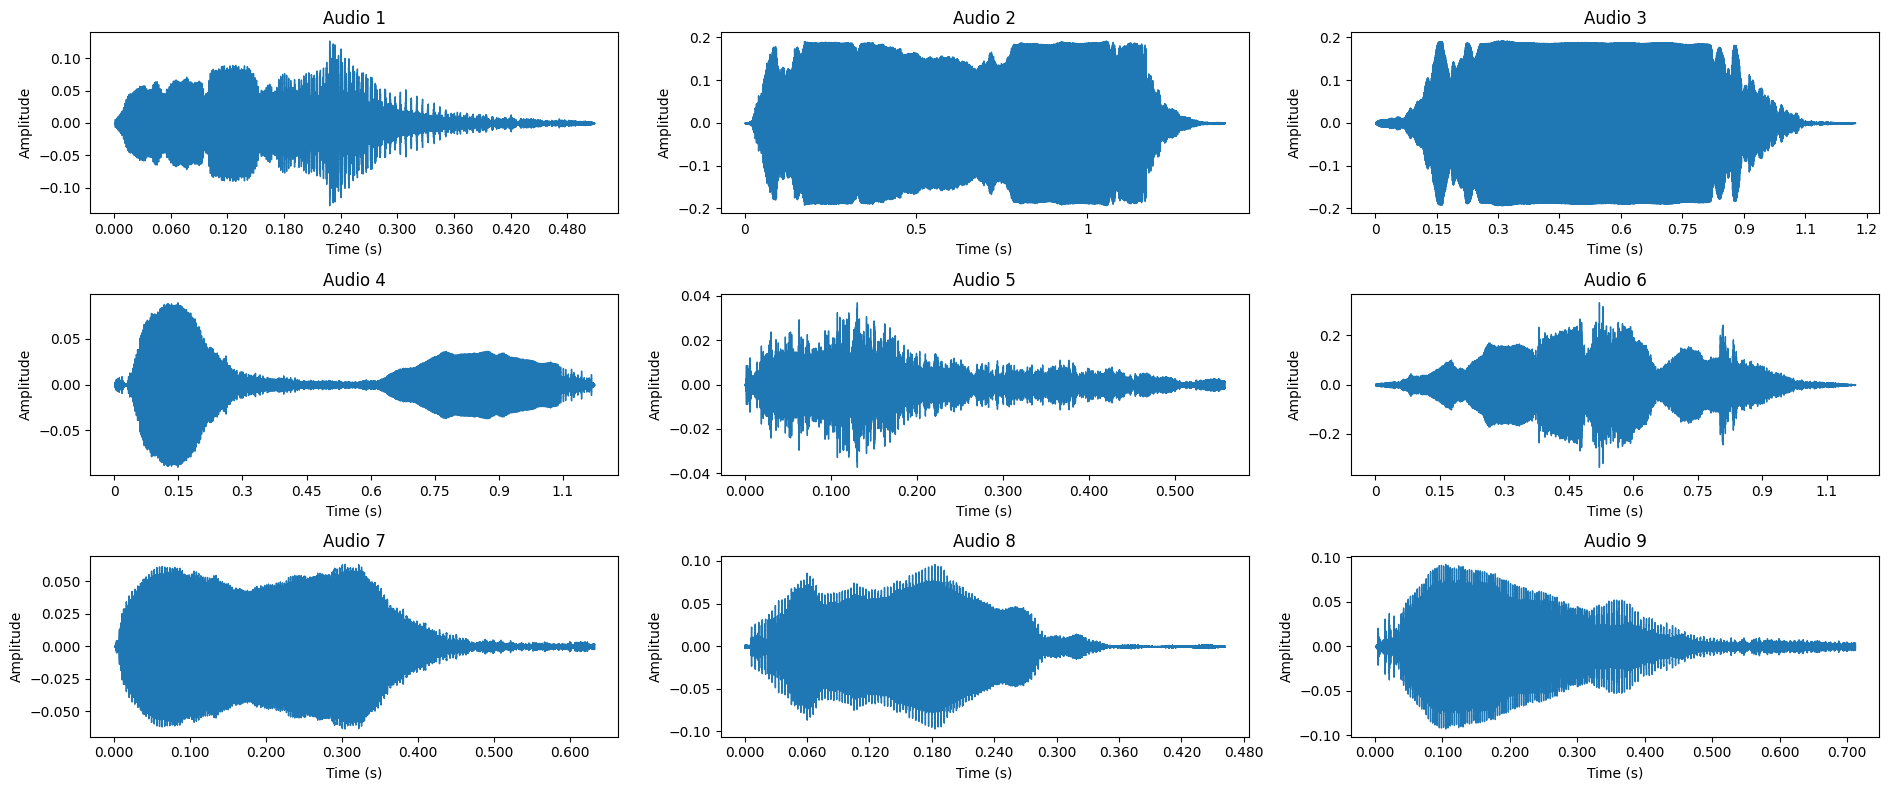

In [9]:
visualize_waveform(folder_data, df['filenames'])

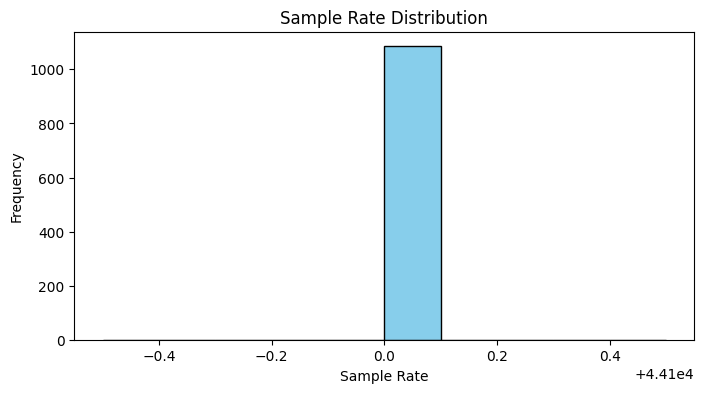

In [10]:
visualize_sr(df['filenames'])

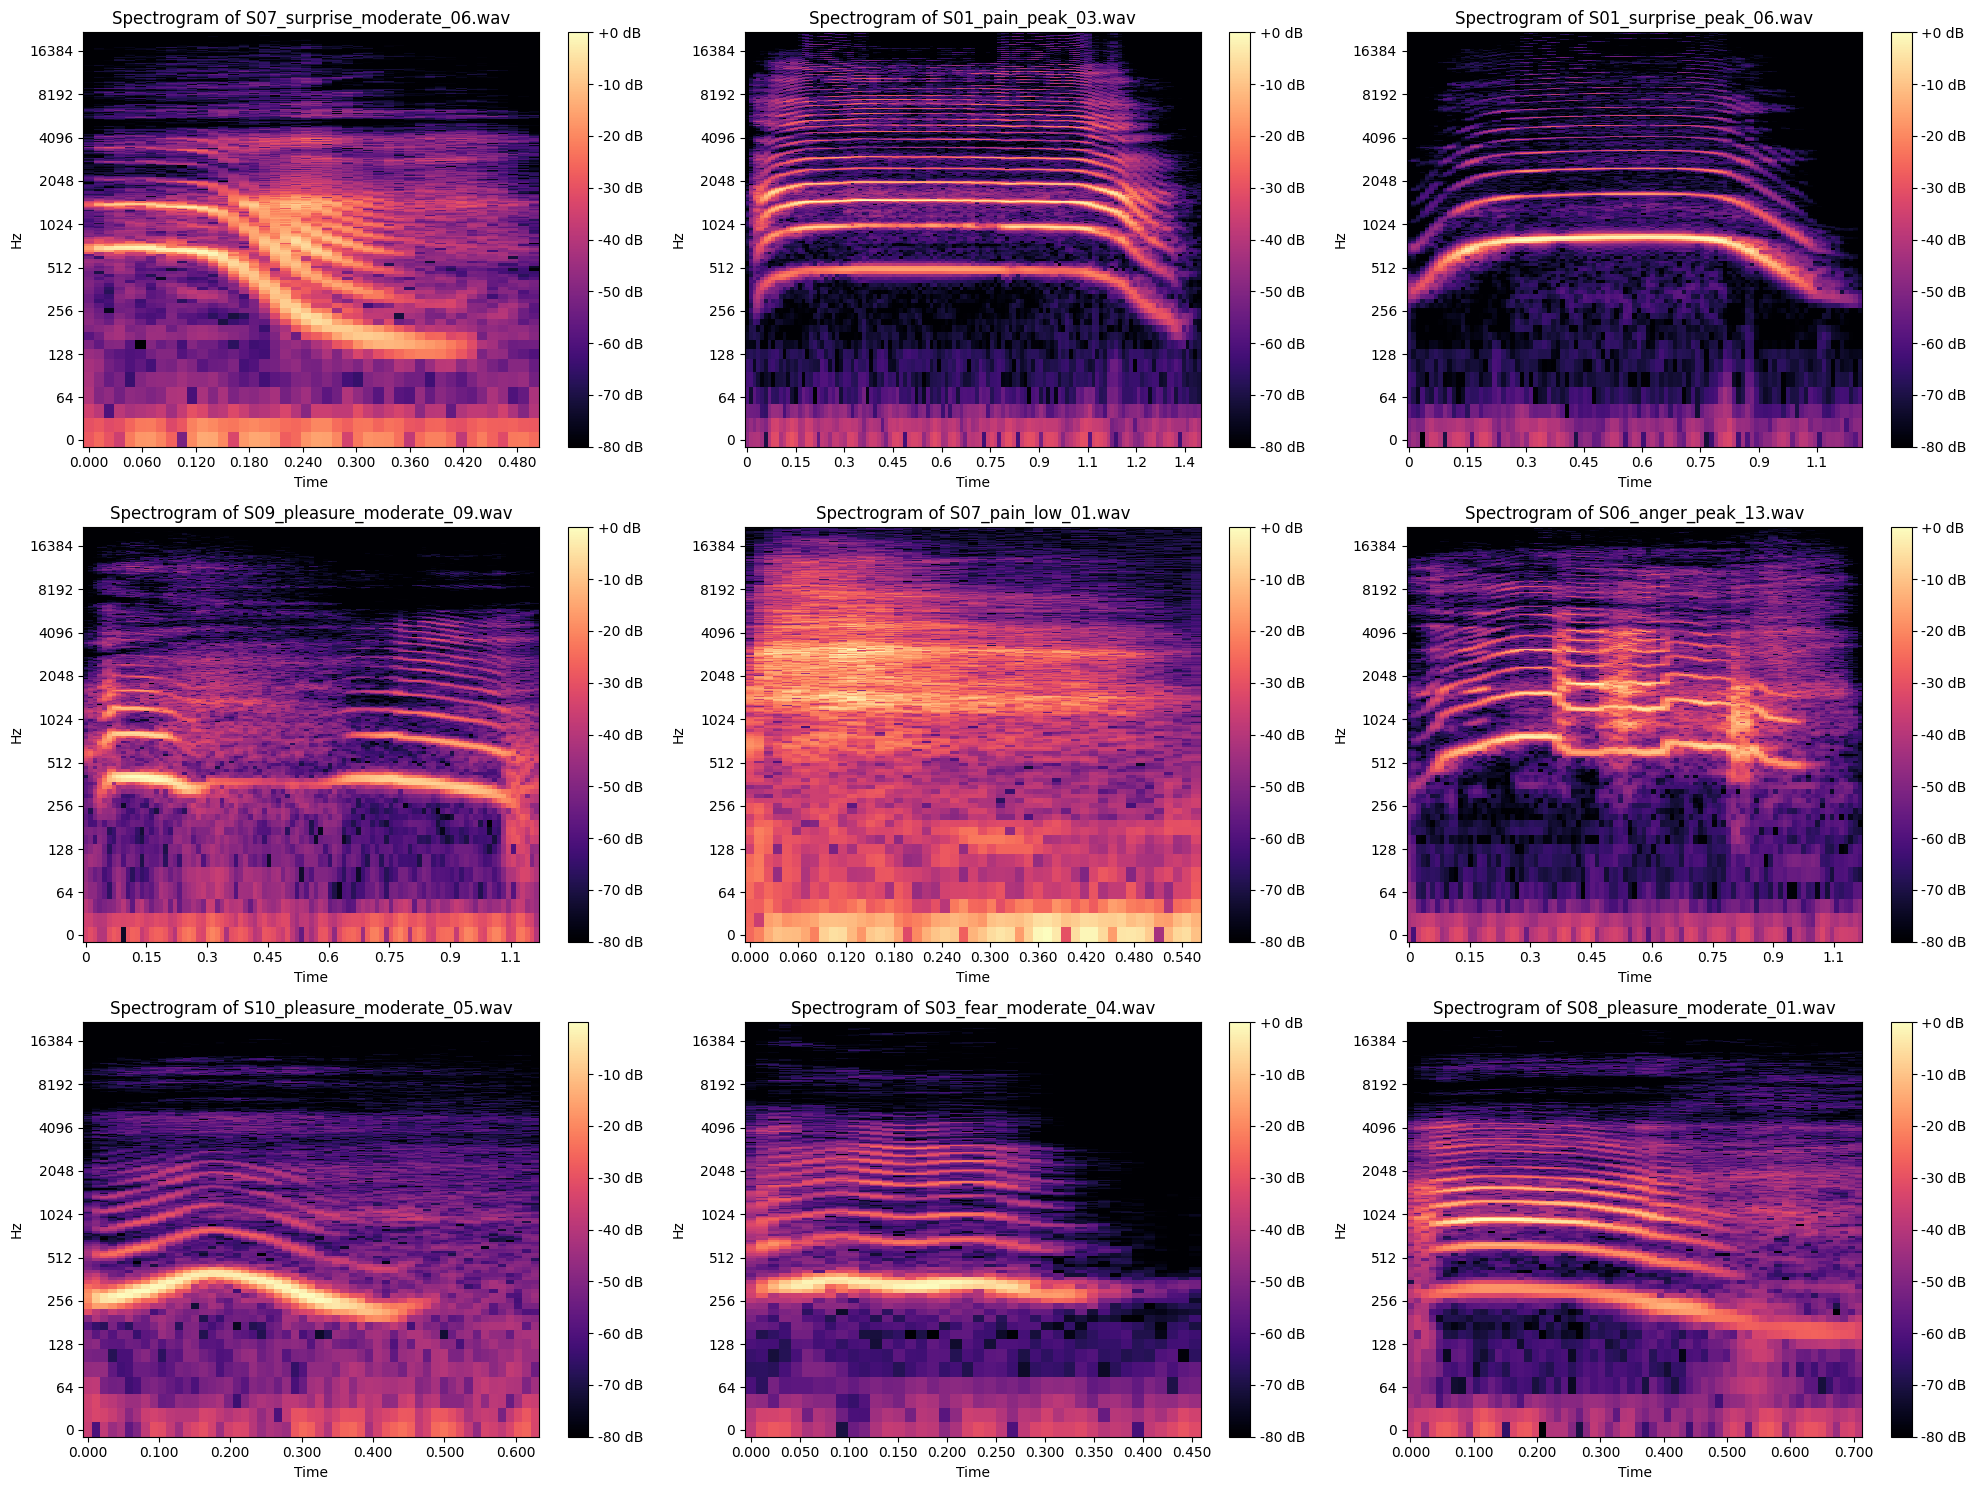

In [11]:
visualize_noise(folder_data, df['filenames'])

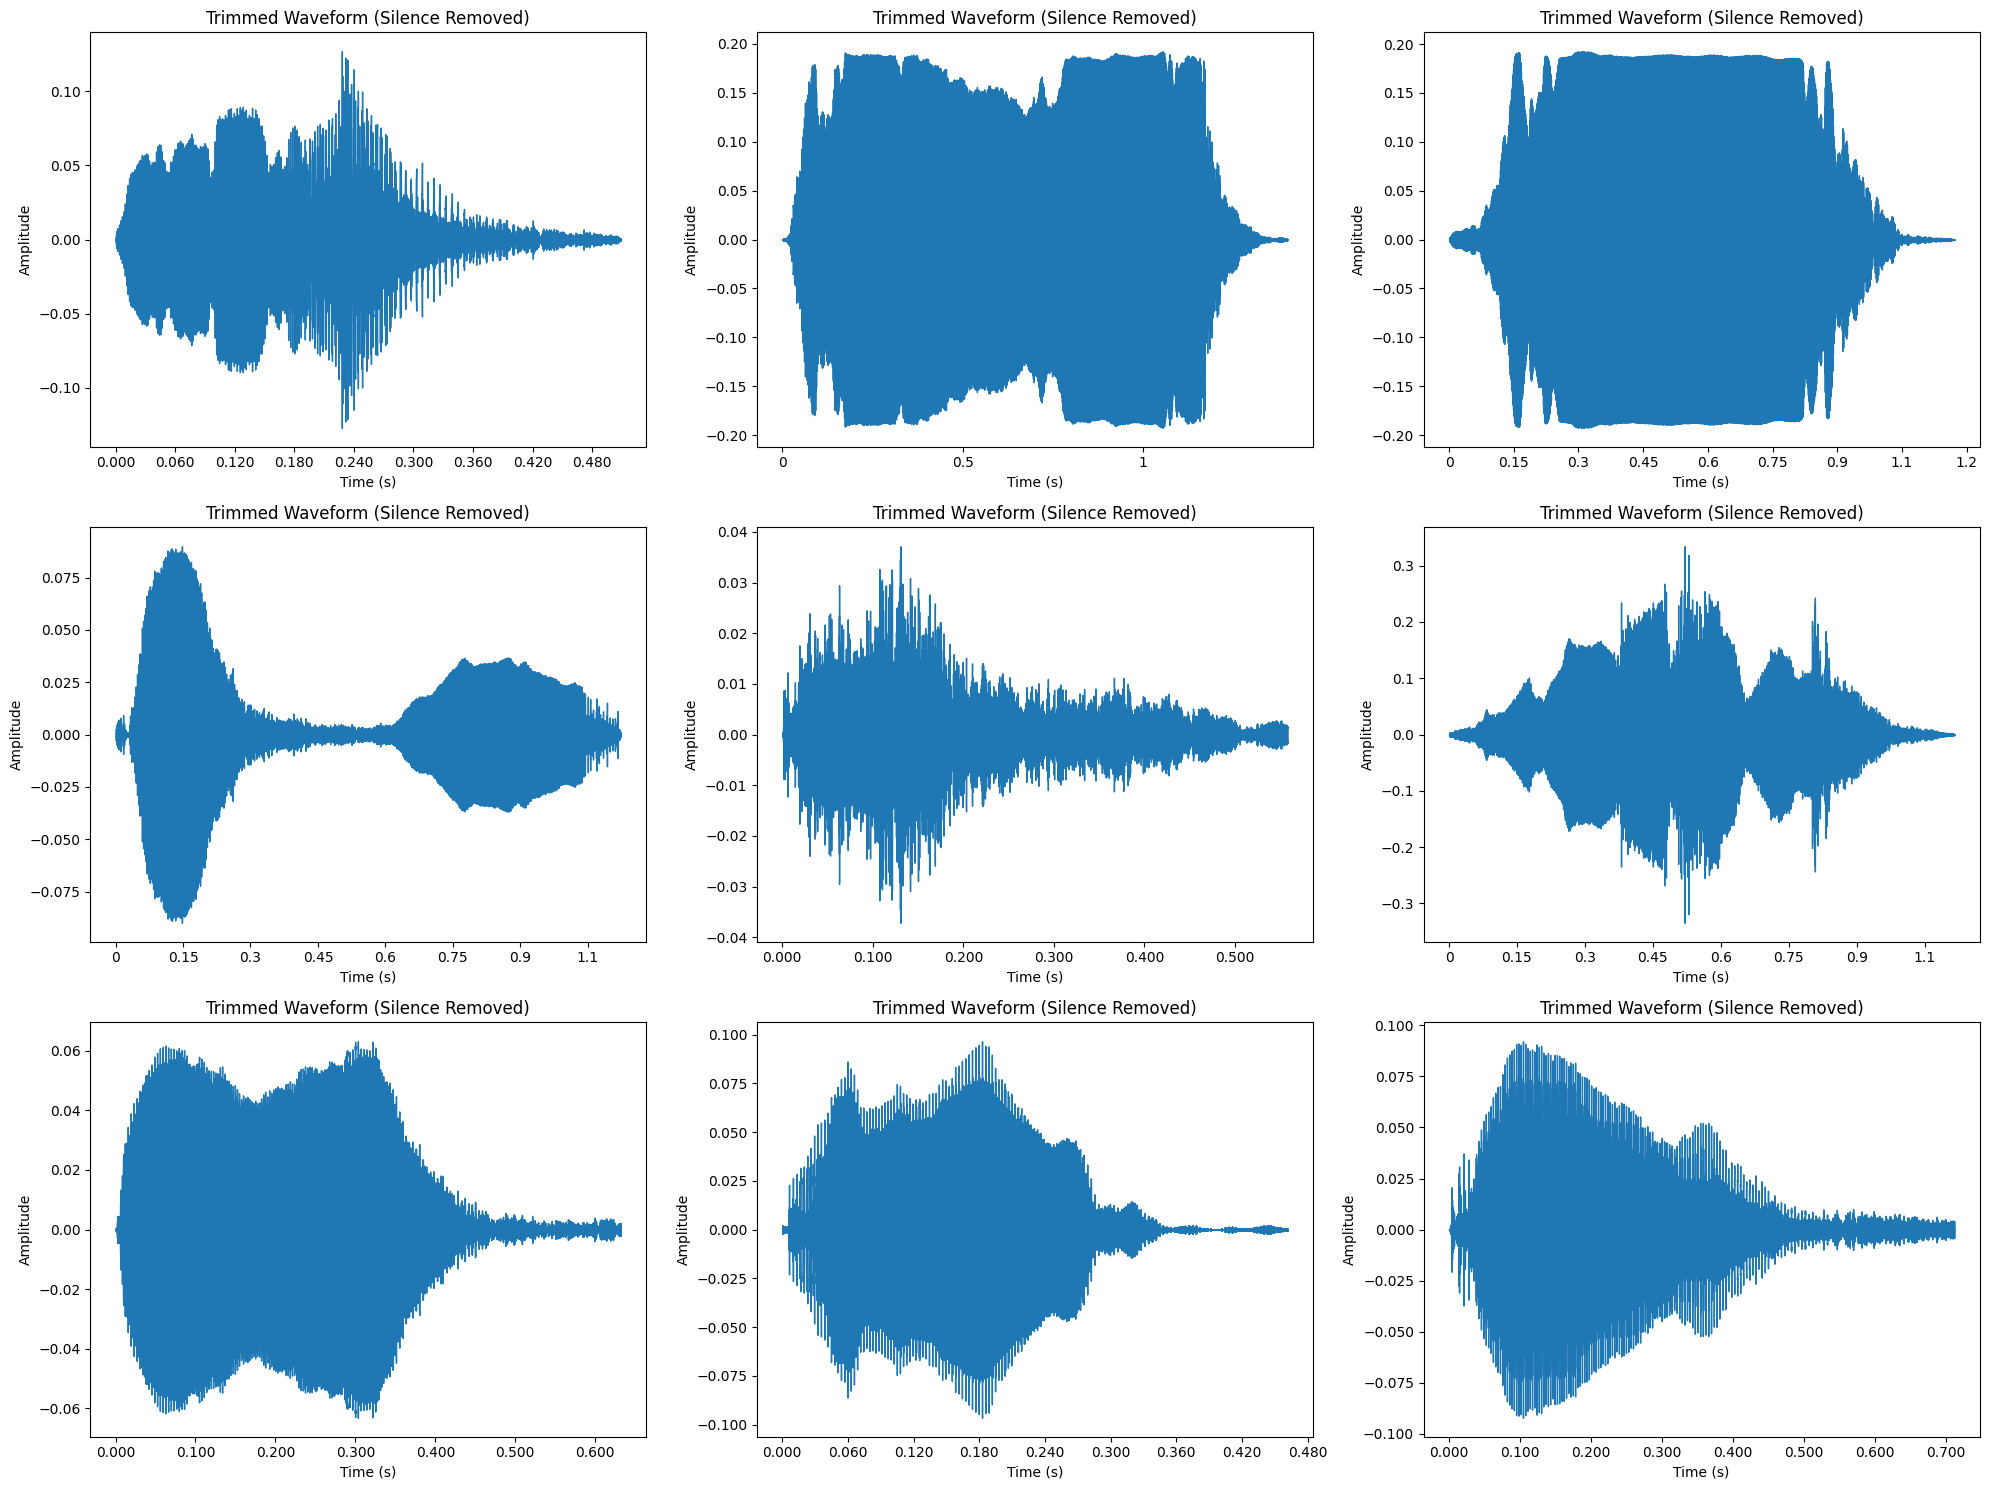

In [12]:
trim_silent_audio(folder_data, df['filenames'])

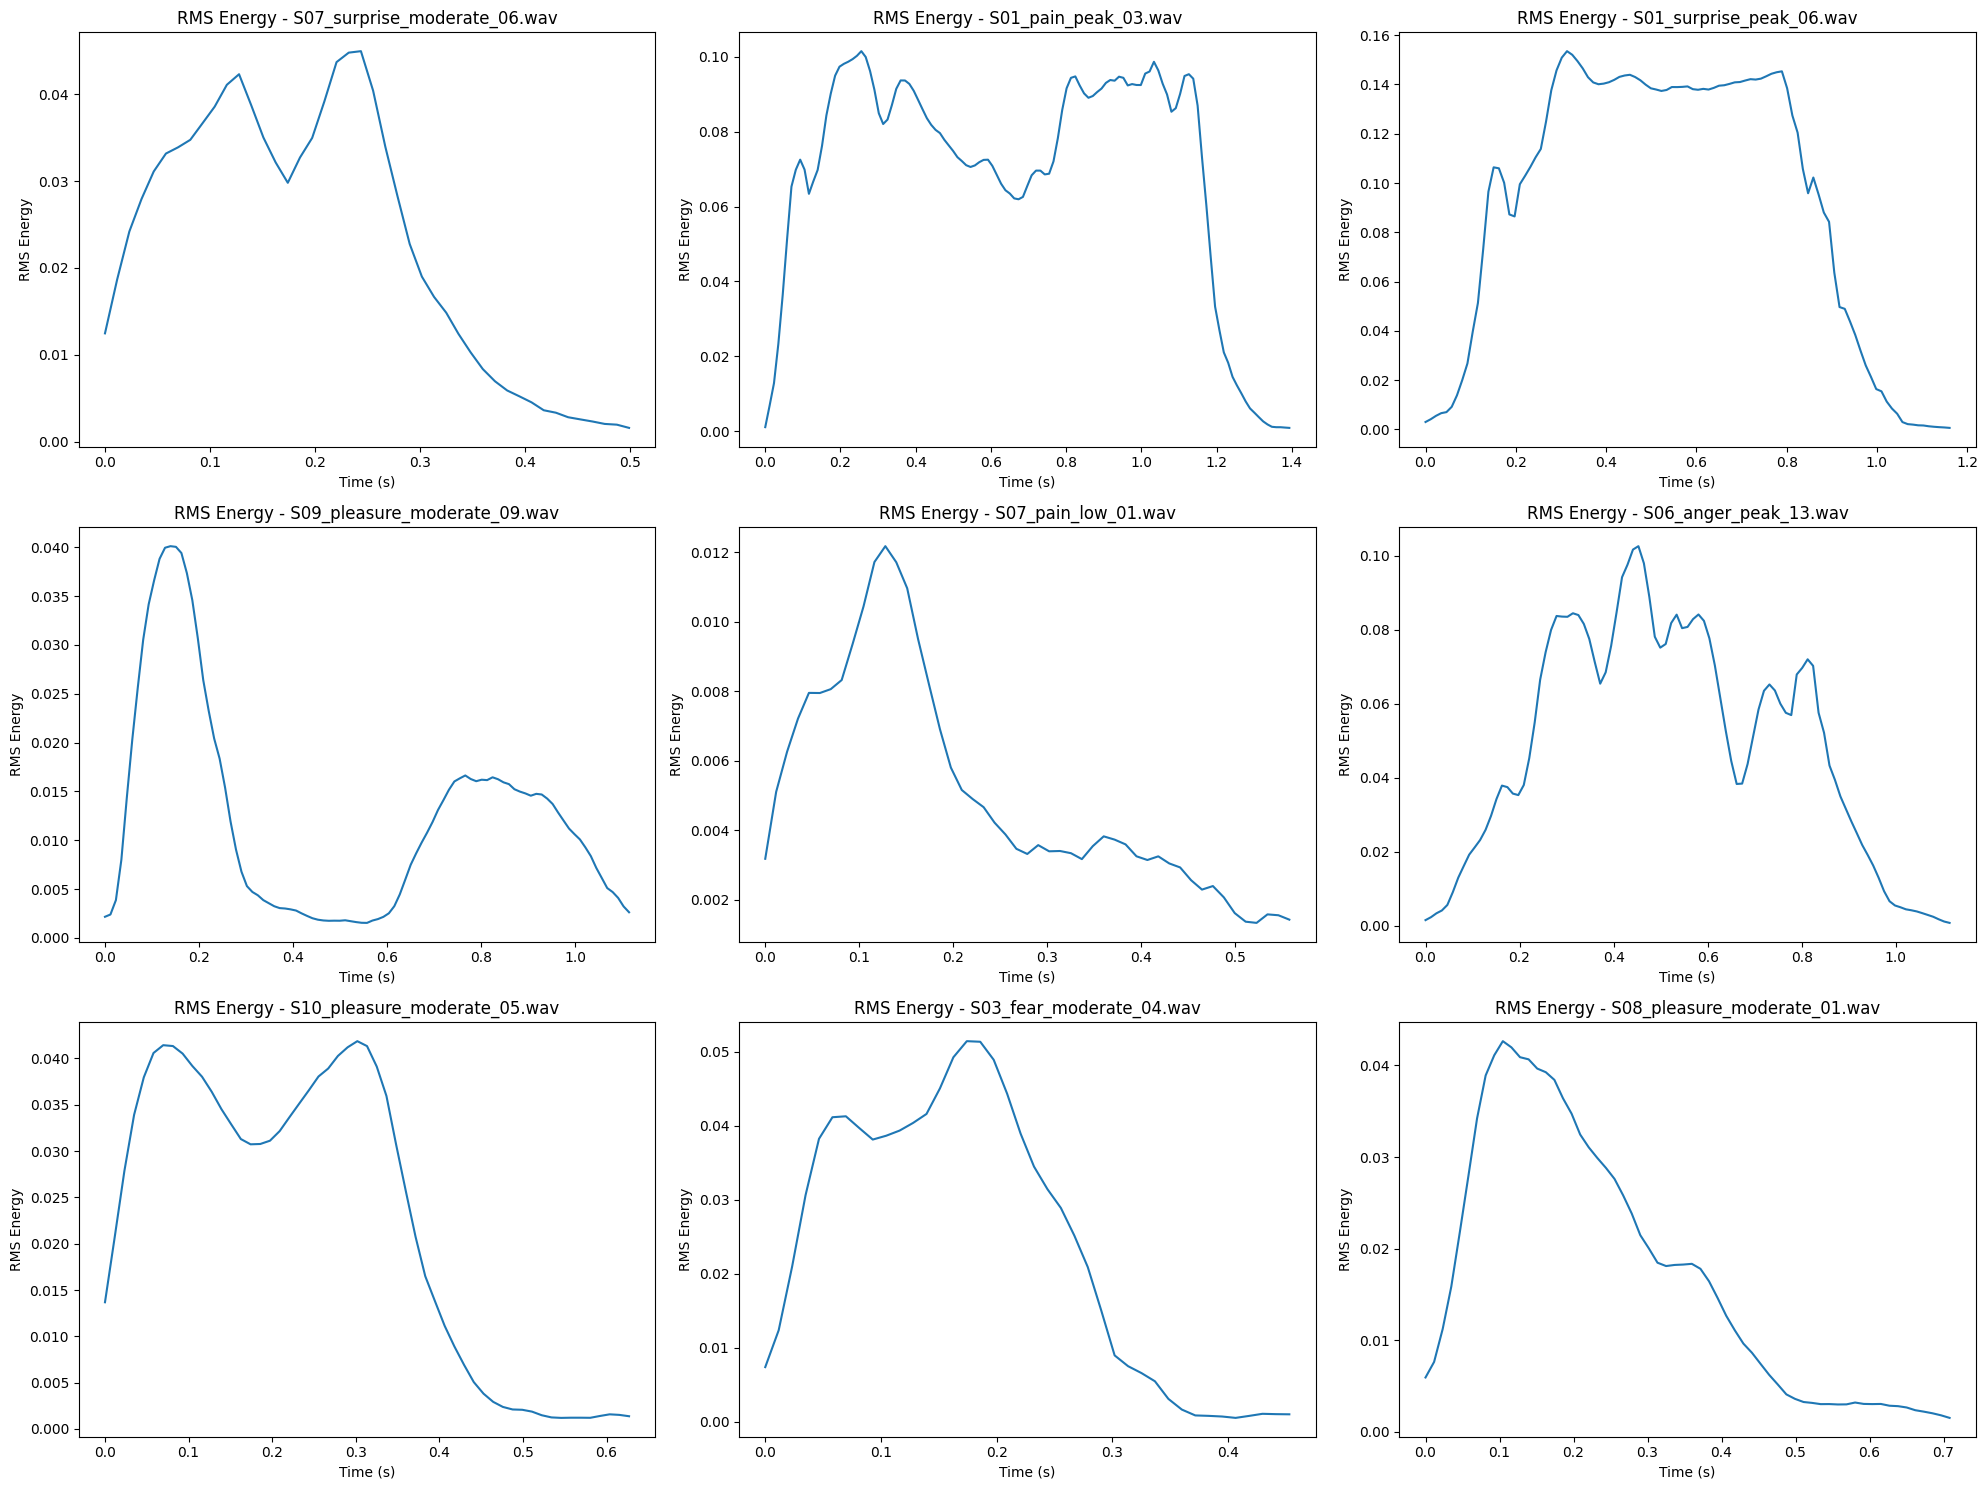

In [13]:
rms_energy(folder_data, df['filenames'])

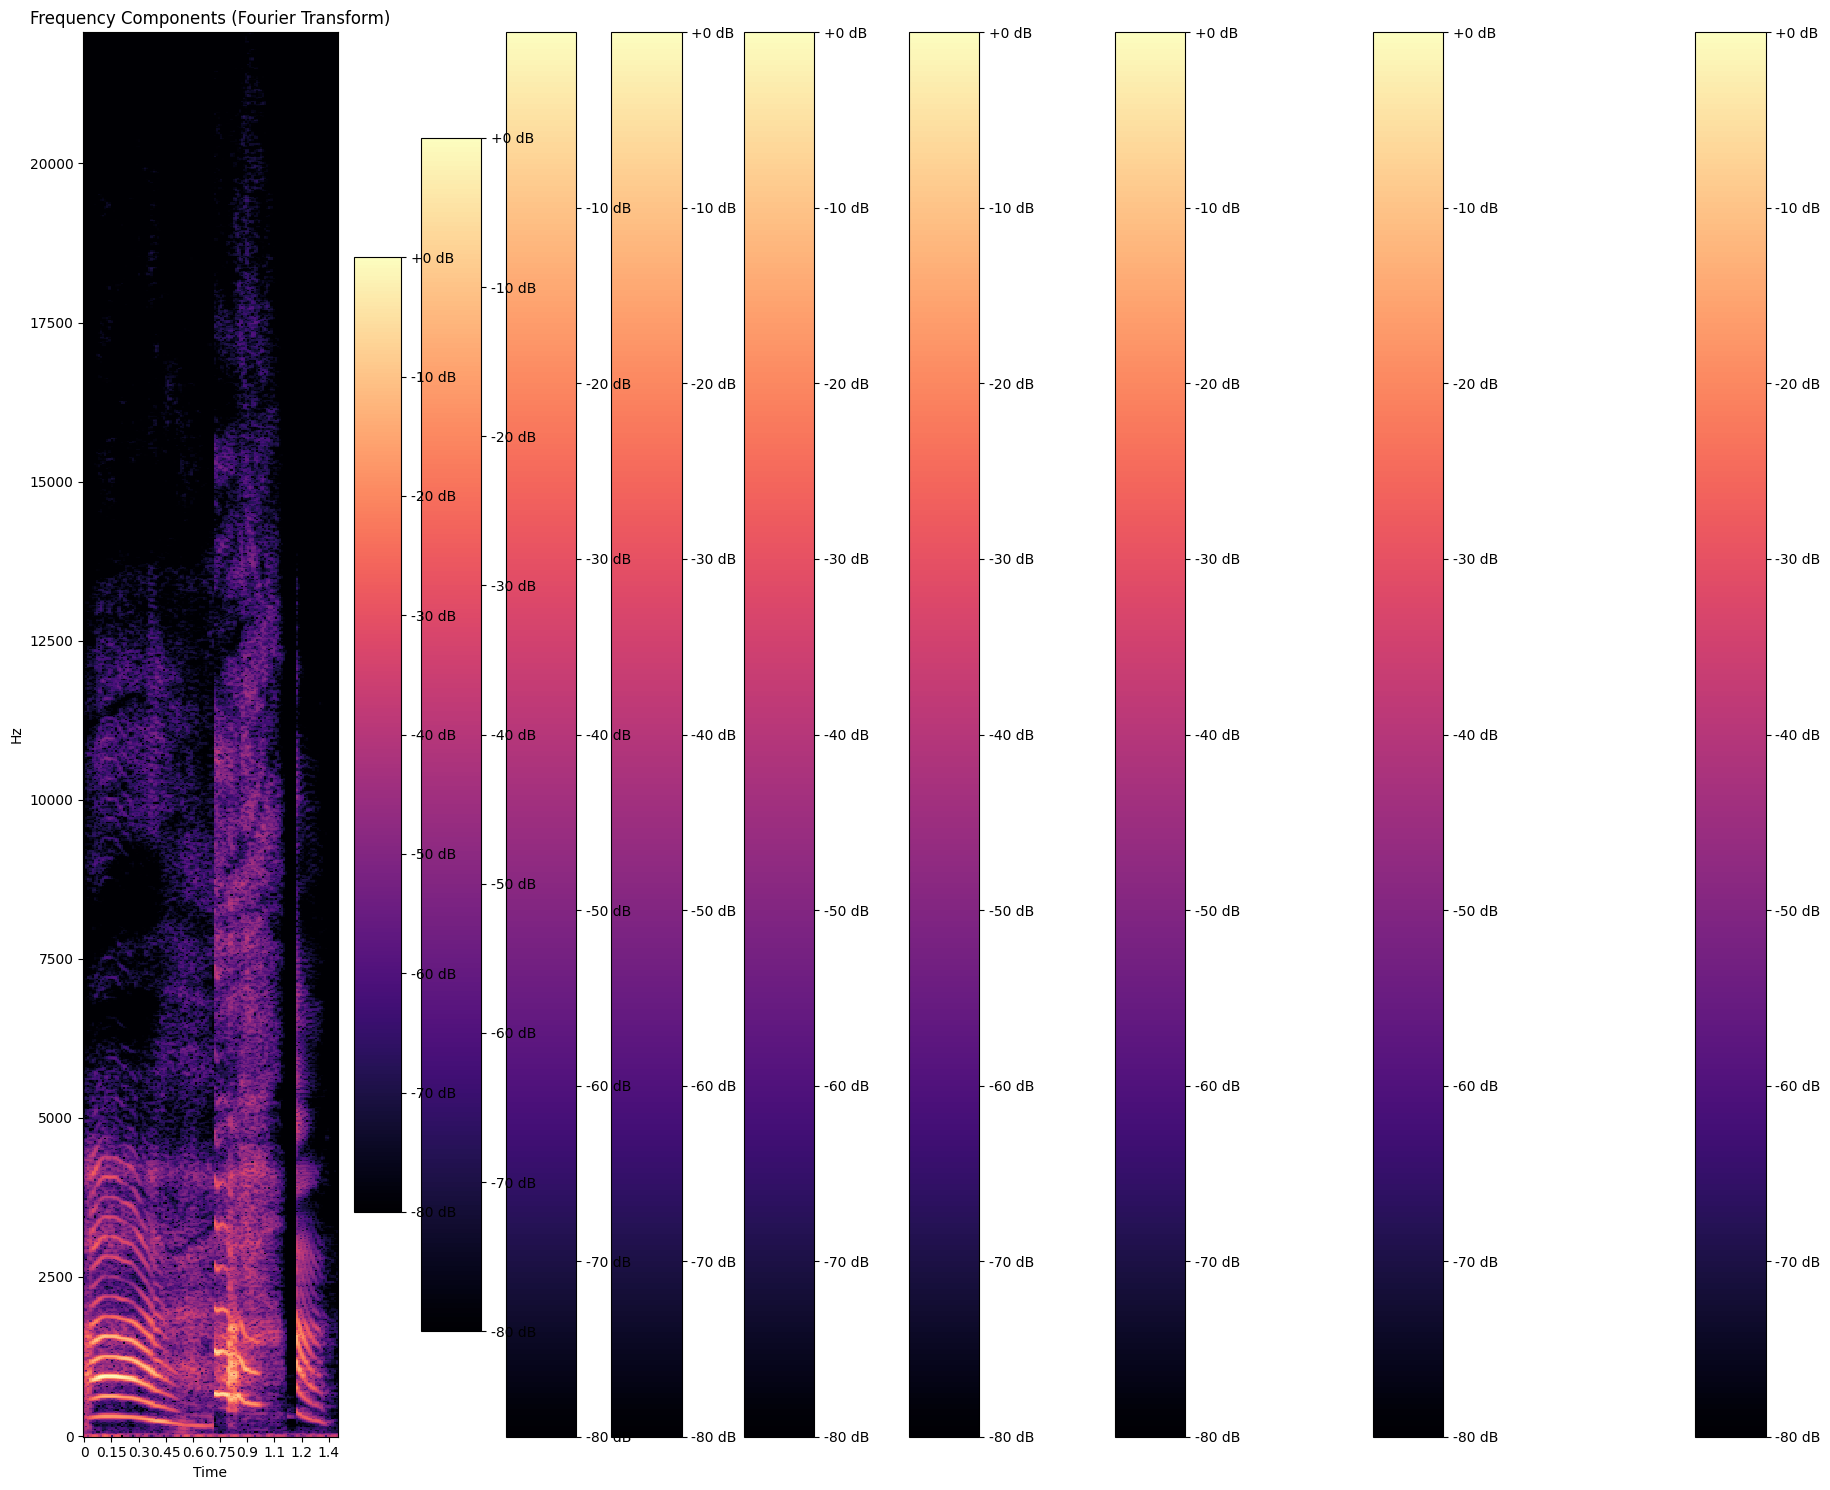

In [14]:
fourier_transform(folder_data, df['filenames'])

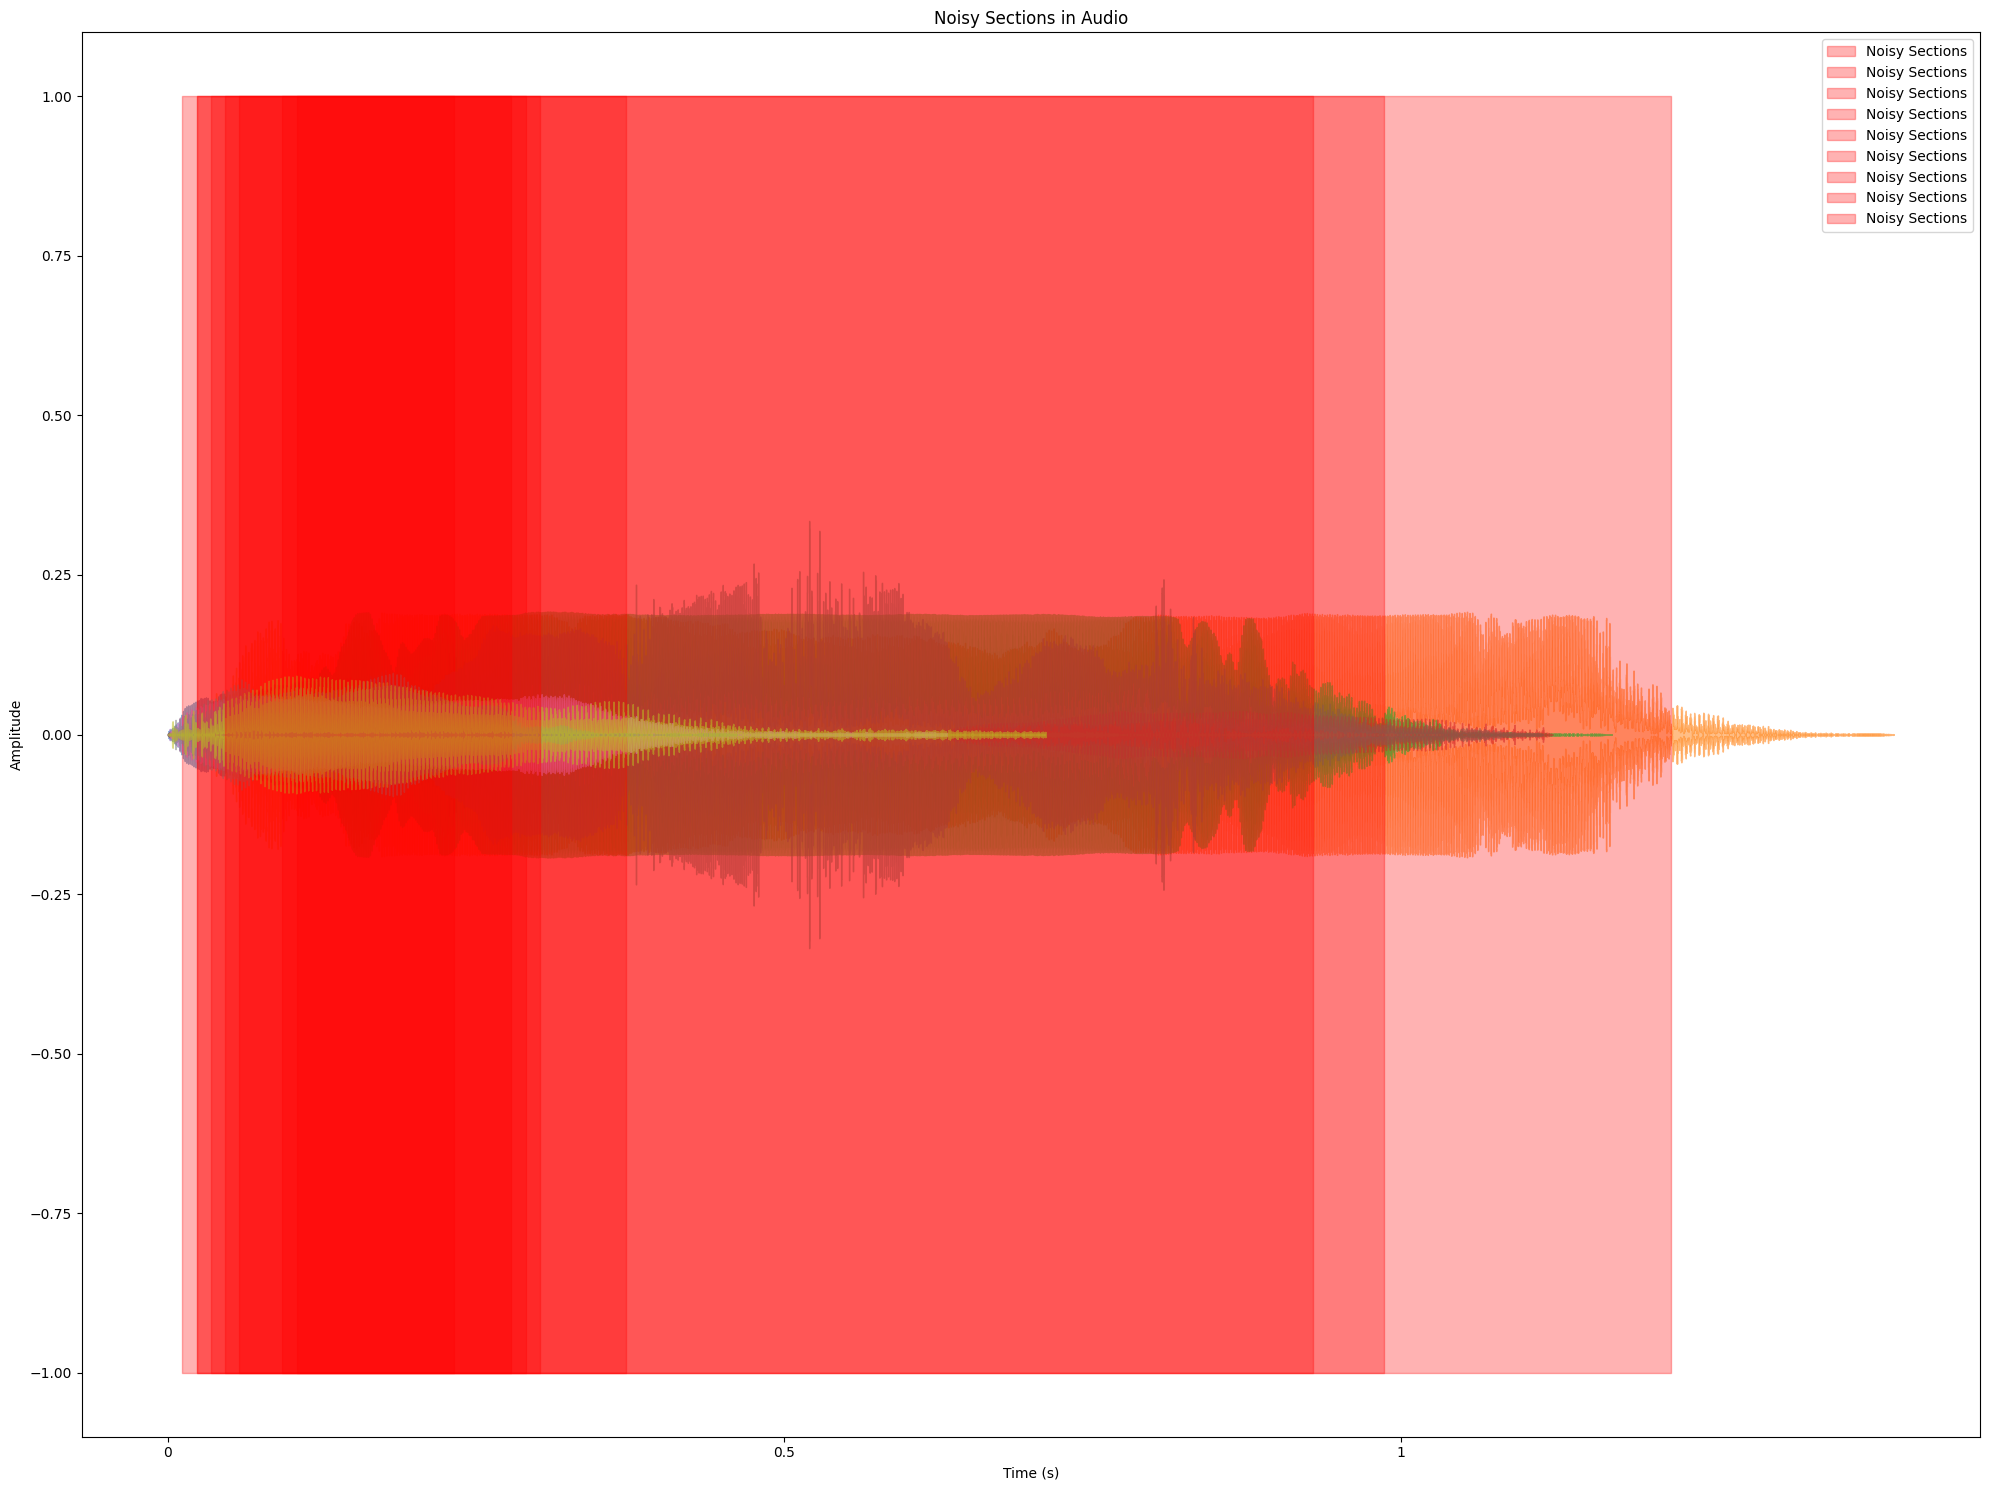

In [15]:
noise_detection(folder_data, df['filenames'])

# Preprocessing

In [16]:
le_train = LabelEncoder()
# df['A_decoded'] = le_A.inverse_transform(df['A_encoded']) jika hendak mengdecode
df['target'] = le_train.fit_transform(df['labels'].values)

In [17]:
le_test = LabelEncoder()
# df['A_decoded'] = le_A.inverse_transform(df['A_encoded']) jika hendak mengdecode
df_test['target'] = le_test.fit_transform(df_test['labels'].values)

In [19]:
y = df['target']
X = df[df.columns.difference(['target', 'labels'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

test_x = df_test[df_test.columns.difference(['target', 'labels'])]
test_y = df_test['target']

X_test = pd.concat([test_x, X_test])
y_test = pd.concat([test_y, y_test])

In [20]:
# Normalisasi audio
def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val == 0:
        return audio
    normalized_audio = audio / max_val
    return normalized_audio

# Pengurangan noise sederhana
def remove_noise(audio, sample_rate):
    # Ambil noise sample dari bagian awal
    noise_sample = audio[:int(sample_rate * 0.5)]
    noise_mean = np.mean(noise_sample)
    
    noise_reduced = audio - noise_mean  # Mengurangi rata-rata noise dari seluruh sinyal
    return noise_reduced

# Trimming bagian senyap
def trim_silent(audio_data):
    trimmed_audio, index = librosa.effects.trim(audio_data, top_db=20)
    return trimmed_audio, index

# Padding atau truncating MFCC
def pad_or_truncate(mfcc, max_length):
    if mfcc.shape[1] < max_length:
        # Padding dengan nol jika MFCC lebih pendek dari panjang maksimum
        pad_width = max_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate jika MFCC lebih panjang dari panjang maksimum
        mfcc = mfcc[:, :max_length]
    return mfcc

# Fungsi utama untuk preprocessing
def main(folders, filenames, max_length=200):
    sound_preprocessing = []
    sample_rates = []
    for fname in filenames:
        audio_data, sample_rate = librosa.load(f'{folders}/{fname}', sr=None)

        # Langkah-langkah preprocessing
        normalize = normalize_audio(audio_data)
        rmv_noise = remove_noise(normalize, sample_rate)
        trimmed_audio, idx = trim_silent(rmv_noise)

        # Ekstraksi MFCC
        mfccs = librosa.feature.mfcc(y=trimmed_audio, sr=sample_rate, n_mfcc=13)
        
        # Padding atau truncating MFCC
        mfccs_padded = pad_or_truncate(mfccs, max_length)
        mfccs_flatten = mfccs_padded.flatten()
        
        # Simpan hasil preprocessing
        sound_preprocessing.append(mfccs_flatten)
        sample_rates.append(sample_rate)
        
    return np.array(sound_preprocessing), sample_rates

# Visualisasi waveform
def visualize_waveform(sounds, sample_rates):
    plt.figure(figsize=(19, 8))
    for idf in range(9):
        plt.subplot(3, 3, idf+1)
        librosa.display.waveshow(sounds[idf], sr=sample_rates[idf])

        plt.title(f"Audio {idf+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

In [21]:
sounds, sample_rates = main(folder_data, X_train['filenames'])

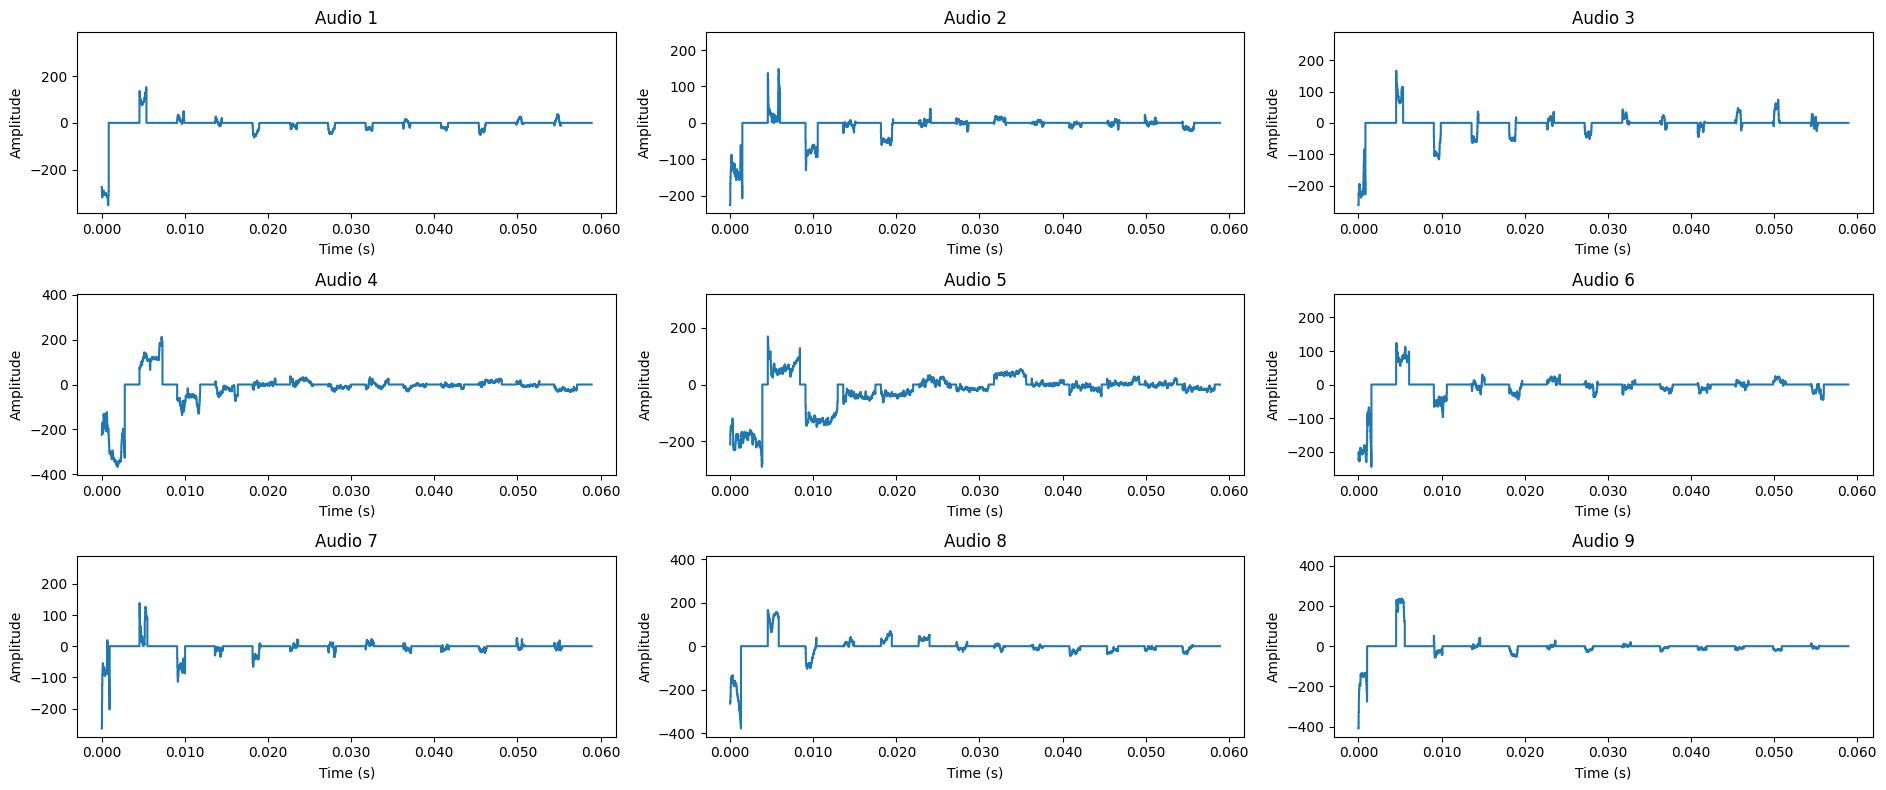

In [22]:
visualize_waveform(sounds, sample_rates)

In [23]:
sounds[:3]

array([[-273.80927, -292.33423, -318.48972, ...,    0.     ,    0.     ,
           0.     ],
       [-225.90929, -167.93602, -148.15851, ...,    0.     ,    0.     ,
           0.     ],
       [-262.50824, -223.78621, -228.31047, ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

# modeling

In [61]:
svm_model = SVC(kernel='linear', C=0.68, class_weight='balanced', decision_function_shape='ovo')

# Train model
svm_model.fit(sounds, y_train)

SVC(C=0.68, class_weight='balanced', decision_function_shape='ovo',
    kernel='linear')

In [25]:
sound_test, sample_rates = main(folder_data, X_test['filenames'])

In [62]:
# Prediksi menggunakan model
y_pred = svm_model.predict(sound_test)

# Evaluasi model
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 77.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       107
           1       0.74      0.87      0.80       106
           2       0.76      0.75      0.76       108
           3       0.73      0.84      0.78       100
           4       0.84      0.81      0.83       111
           5       0.81      0.59      0.69       111

    accuracy                           0.77       643
   macro avg       0.78      0.77      0.77       643
weighted avg       0.78      0.77      0.77       643



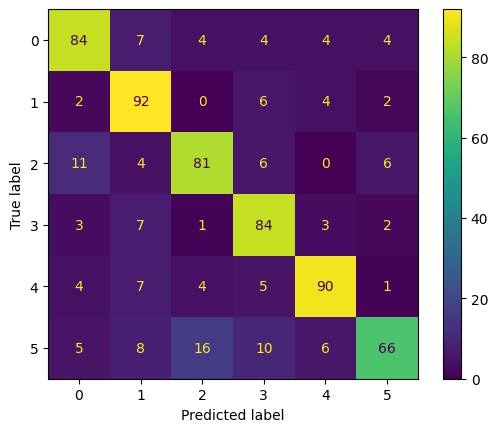

In [63]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

In [64]:
test1, srate = main('/kaggle/input/test12', ['record_out.wav'])

In [66]:
sounds

array([[-273.80927, -292.33423, -318.48972, ...,    0.     ,    0.     ,
           0.     ],
       [-225.90929, -167.93602, -148.15851, ...,    0.     ,    0.     ,
           0.     ],
       [-262.50824, -223.78621, -228.31047, ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [-235.70505, -248.34164, -299.00174, ...,    0.     ,    0.     ,
           0.     ],
       [-316.8831 , -241.08798, -204.55472, ...,    0.     ,    0.     ,
           0.     ],
       [-233.23831, -183.9766 , -159.97447, ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [49]:
svm_model.predict(test1)

array([4])

In [67]:
df_test[df_test['target'] == 4]

,filenames,labels,target
5,S03_pleasure_peak_10.wav,pleasure,4
7,S09_pleasure_low_031.wav,pleasure,4
11,S07_pleasure_peak_07.wav,pleasure,4
15,S05_pleasure_moderate_10.wav,pleasure,4
17,S05_pleasure_strong_15.wav,pleasure,4
...,...,...,...
459,S09_pleasure_moderate_07.wav,pleasure,4
466,S04_pleasure_strong_04.wav,pleasure,4
468,S04_pleasure_moderate_08.wav,pleasure,4
472,S09_pleasure_peak_107.wav,pleasure,4


In [68]:
le_test.inverse_transform(df_test['target'])[5]

'pleasure'